In [136]:
from data import *

folder_path = "Data/TestRecordings"
participant = "TestPat003"

rec = Recording(os.path.join(folder_path, participant))
rec.calc_events_all_conditions()

f:\Python\GazeBasedSelection\data.py:26: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  scene_data = pd.read_table(os.path.join(path, condition, "SceneData.tsv"), sep="\t", decimal=",")
f:\Python\GazeBasedSelection\data.py:26: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  scene_data = pd.read_table(os.path.join(path, condition, "SceneData.tsv"), sep="\t", decimal=",")
100%|██████████| 4/4 [00:21<00:00,  5.34s/it]


In [137]:
round_results = rec.summarize_rounds("nod")

In [138]:
rec["nod"]["SceneData"].Msg.unique()

array([nan, 'StartGame', 'Correct target selected', 'MainTargetDestroyed',
       'EndGame', 'Incorrect target selected', 'NonMaintargetDestroyed'],
      dtype=object)

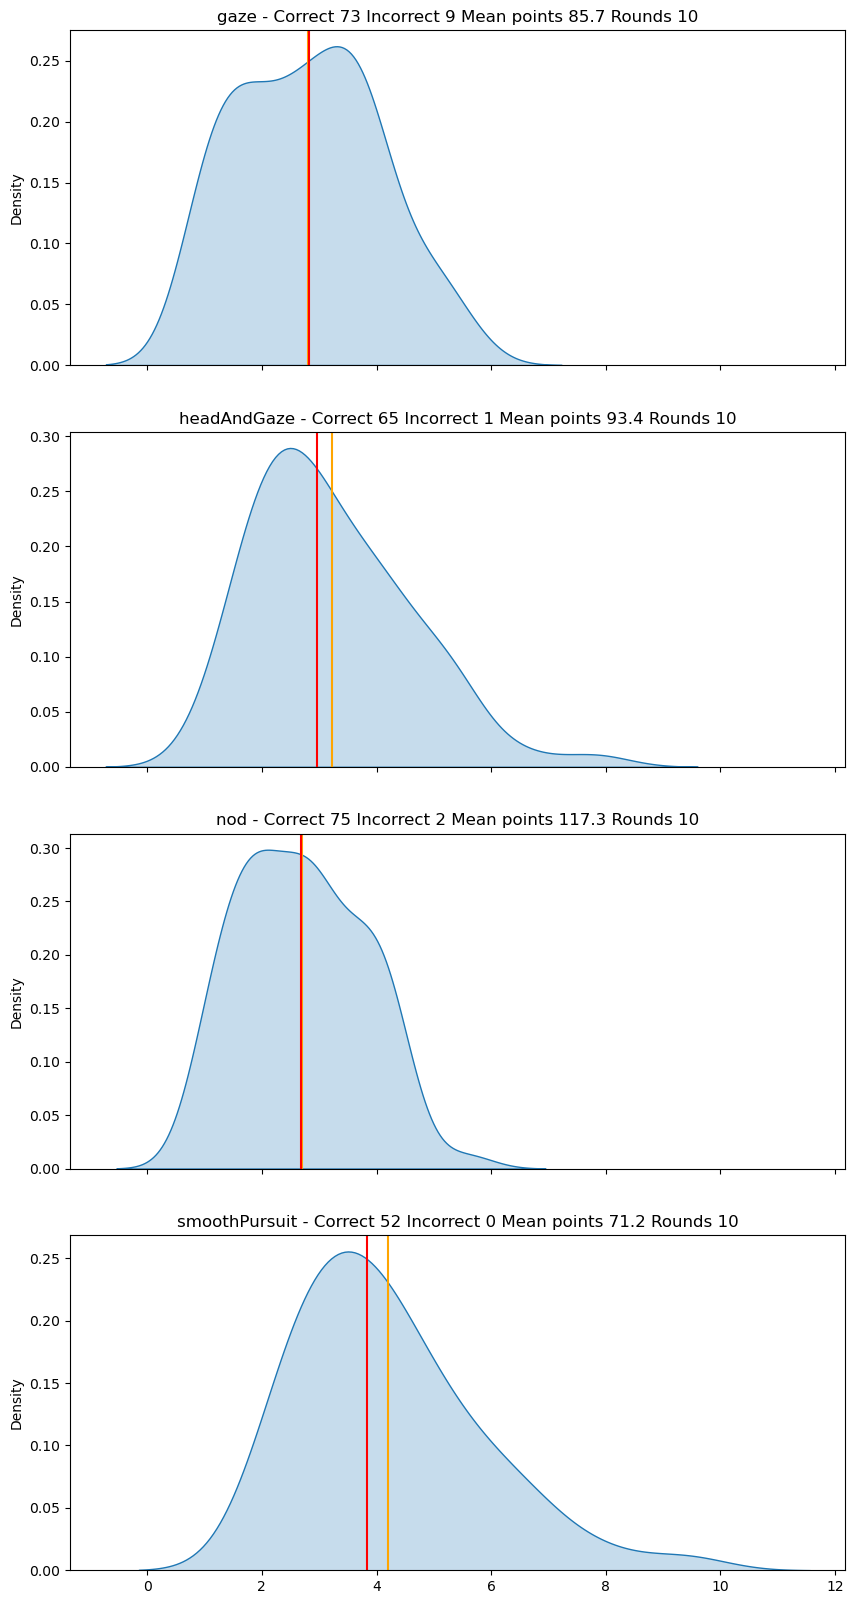

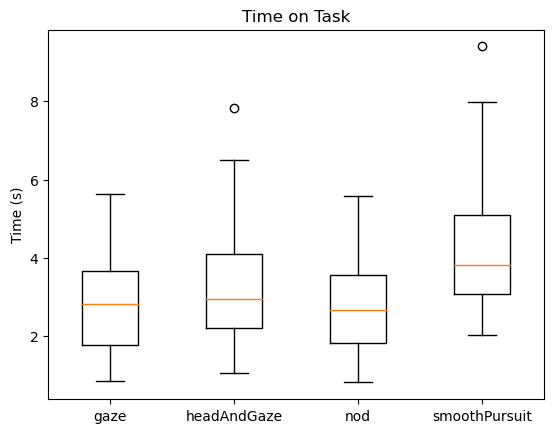

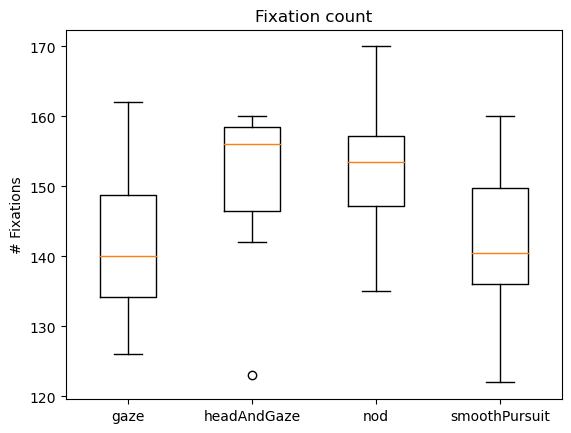

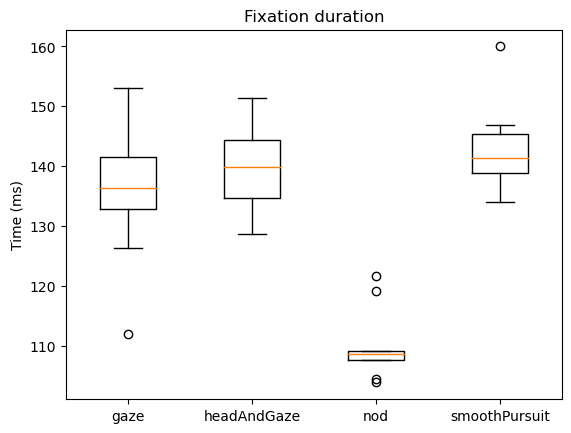

In [139]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axs = plt.subplots(len(Recording.conditions), sharex=True, figsize=(10,20))
all_time_on_tasks = dict()
all_fixation_count = dict()
all_fixation_duration = dict()
for i, condition in enumerate(Recording.conditions):
    round_results = rec.summarize_rounds(condition)
    time_on_task = list()
    correct = 0
    incorrect = 0
    rounds_without_change = len(round_results)
    points = list()
    fixation_count = list()
    fixation_duration = list()
    for k in round_results:
        time_on_task += round_results[k]["TimeOnTask"]
        correct += round_results[k]["Correct"]
        incorrect += round_results[k]["Incorrect"]
        points.append(round_results[k]["Points"])
        fixation_count.append(round_results[k]["FixationCount"])
        fixation_duration.append(round_results[k]["MeanFixationDuration"])
    sns.kdeplot(time_on_task, fill=True, ax=axs[i])
    y_min, y_max = axs[i].get_ylim()
    axs[i].axvline(np.mean(time_on_task), 0, 1, color="orange")
    axs[i].axvline(np.median(time_on_task), 0, 1, color="red")
    axs[i].set_title(f"{condition} - Correct {correct} Incorrect {incorrect} Mean points {np.mean(points)} Rounds {rounds_without_change}")
    all_time_on_tasks[condition] = time_on_task
    all_fixation_count[condition] = fixation_count
    all_fixation_duration[condition] = fixation_duration
plt.show()

def create_boxplot(d, title, ylabel):
    _, ax = plt.subplots()
    ax.boxplot(d.values())
    ax.set_xticklabels(d.keys())
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.show()

create_boxplot(all_time_on_tasks, "Time on Task", "Time (s)")
create_boxplot(all_fixation_count, "Fixation count", "# Fixations")
create_boxplot(all_fixation_duration, "Fixation duration", "Time (ms)")

# fig, ax = plt.subplots()
# ax.boxplot(all_time_on_tasks.values())
# ax.set_xticklabels(all_time_on_tasks.keys())
# ax.set_ylabel("Time on selection (s)")
# ax.set_title("Time on Task")
# plt.show()



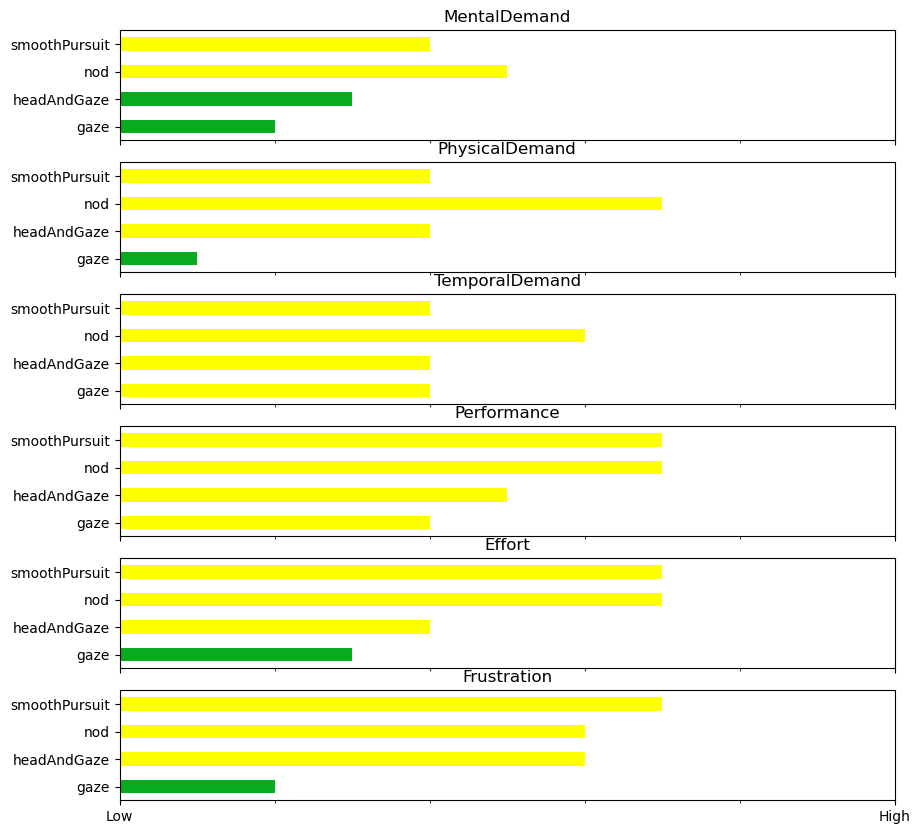

In [140]:
import matplotlib.pyplot as plt
import utils
_, axs = plt.subplots(len(rec["answers"]), sharex=True, sharey=True, figsize=(10, 10))
i = 0
for question, row in rec["answers"].iterrows():
    row.plot(
        kind="barh", 
        color = [utils.get_color(x) for x in row],
        title=question.replace("tlx_", ""), 
        ax=axs[i])
    axs[i].set_xticks([0, 100], ["Low", "High"])
    i += 1
plt.show()

In [141]:
scene_data = rec["nod"]["SceneData"]
scene_data.loc[scene_data.Msg.apply(lambda x: "Correct target selected" in str(x)), ["EyeDataTimestamp", "Msg"]]

,EyeDataTimestamp,Msg
16966,1726227320323,Correct target selected
17179,1726227322689,Correct target selected
17542,1726227326721,Correct target selected
18200,1726227334028,Correct target selected
18787,1726227340546,Correct target selected
...,...,...
51402,1726227702813,Correct target selected
51754,1726227706723,Correct target selected
52161,1726227711243,Correct target selected
52534,1726227715386,Correct target selected


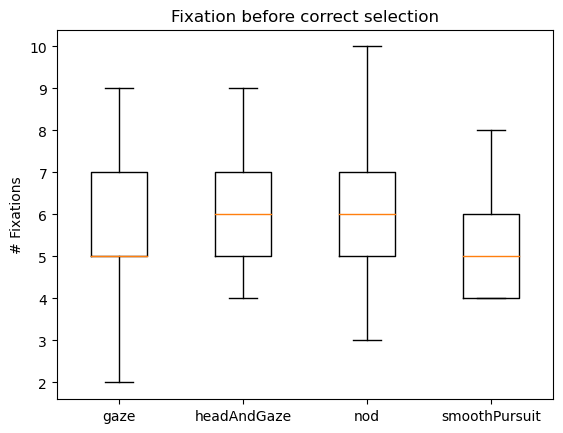

In [142]:
count_fixations = dict()
condition = "nod"
for condition in Recording.conditions:
    count_fixations[condition] = list()
    gaze120 = rec[condition]["Gaze120"]
    scene_data = rec[condition]["SceneData"]
    final_rounds = rec.get_final_rounds(condition)
    for _, row in final_rounds.iterrows():
        start, end = row[["StartDeviceTime", "EndDeviceTime"]]
        gaze_round = gaze120.loc[(gaze120["System Timestamp"] >= start) & (gaze120["System Timestamp"] <= end), ["System Timestamp", "Event"]]
        scene_data_round = scene_data.loc[(scene_data["EyeDataTimestamp"] >= start) & (scene_data["EyeDataTimestamp"] <= end), ["EyeDataTimestamp", "Msg"]]
        t_destroy = scene_data_round.loc[scene_data_round.Msg.apply(lambda x: "Correct target selected" in str(x)), "EyeDataTimestamp"].to_numpy()
        for t in t_destroy:
            fixations = gaze_round.loc[(gaze_round["System Timestamp"] < t) & (gaze_round["System Timestamp"] > t - 1000) & (gaze_round["Event"] != "Saccade"), "Event"].unique()
            count_fixations[condition].append(len(fixations))

create_boxplot(count_fixations, "Fixation before correct selection", "# Fixations")


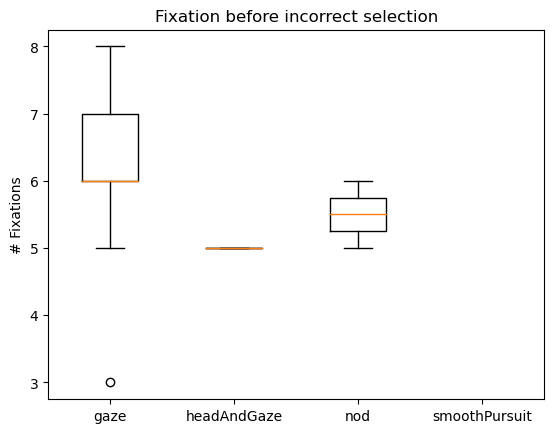

In [143]:
count_fixations = dict()

for condition in Recording.conditions:
    count_fixations[condition] = list()
    gaze120 = rec[condition]["Gaze120"]
    scene_data = rec[condition]["SceneData"]
    final_rounds = rec.get_final_rounds(condition)
    for _, row in final_rounds.iterrows():
        start, end = row[["StartDeviceTime", "EndDeviceTime"]]
        gaze_round = gaze120.loc[(gaze120["System Timestamp"] >= start) & (gaze120["System Timestamp"] <= end), ["System Timestamp", "Event"]]
        scene_data_round = scene_data.loc[(scene_data["EyeDataTimestamp"] >= start) & (scene_data["EyeDataTimestamp"] <= end), ["EyeDataTimestamp", "Msg"]]
        t_destroy = scene_data_round.loc[scene_data_round.Msg.apply(lambda x: "Incorrect target selected" in str(x)), "EyeDataTimestamp"].to_numpy()
        for t in t_destroy:
            fixations = gaze_round.loc[(gaze_round["System Timestamp"] < t) & (gaze_round["System Timestamp"] > t - 1000) & (gaze_round["Event"] != "Saccade"), "Event"].unique()
            count_fixations[condition].append(len(fixations))

create_boxplot(count_fixations, "Fixation before incorrect selection", "# Fixations")


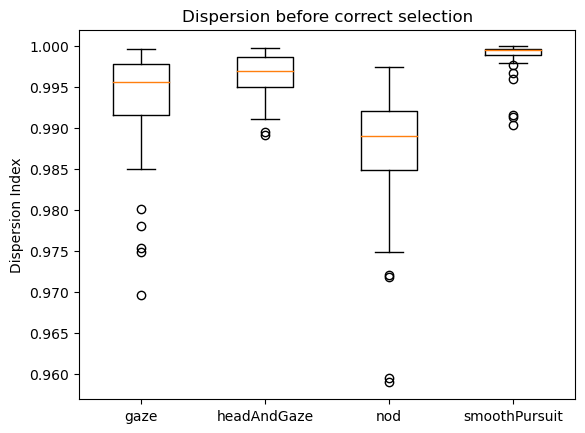

In [144]:
import utils
dispersion = dict()
time_window = 1000
condition = "nod"
errors = list()
for condition in Recording.conditions:
    dispersion[condition] = list()
    gaze120 = rec[condition]["Gaze120"]
    scene_data = rec[condition]["SceneData"]
    final_rounds = rec.get_final_rounds(condition)
    for _, row in final_rounds.iterrows():
        start, end = row[["StartDeviceTime", "EndDeviceTime"]]
        gaze_round = gaze120.loc[(gaze120["System Timestamp"] >= start) & (gaze120["System Timestamp"] <= end)]
        scene_data_round = scene_data.loc[(scene_data["EyeDataTimestamp"] >= start) & (scene_data["EyeDataTimestamp"] <= end), ["EyeDataTimestamp", "Msg"]]
        t_destroy = scene_data_round.loc[scene_data_round.Msg.apply(lambda x: "Correct target selected" in str(x)), "EyeDataTimestamp"].to_numpy()
        for t in t_destroy:
            gvs = gaze_round.loc[(gaze_round["System Timestamp"] < t) & (gaze_round["System Timestamp"] > t - time_window) & (gaze_round["Event"] != "Saccade"), ["Local Gaze Direction %s" % x for x in ["X", "Y", "Z"]]].to_numpy()
            disp = utils.calc_dispersion_index(gvs)
            dispersion[condition].append(disp)
            if disp > 1:
                errors.append(gvs)

create_boxplot(dispersion, "Dispersion before correct selection", "Dispersion Index")

<Axes: >

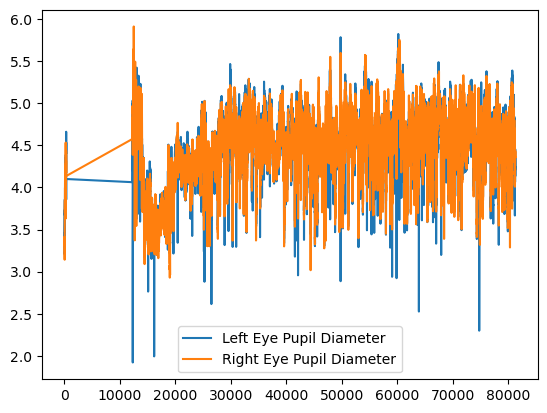

In [145]:
gaze120.loc[:, [x for x in gaze120.columns if "Diameter" in x]].plot()

In [146]:
[x for x in gaze120.columns if "Diameter" in x]

['Left Eye Pupil Diameter', 'Right Eye Pupil Diameter']

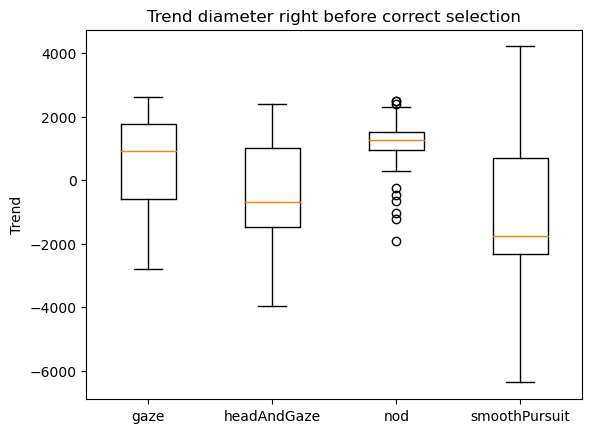

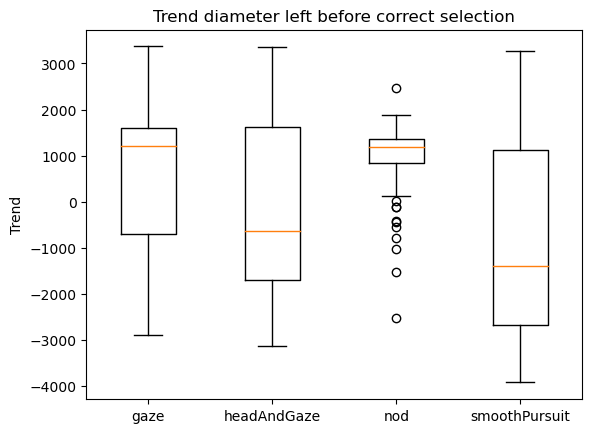

In [147]:
import utils
trend = {"Right": dict(), "Left": dict()}
time_window = 1000
condition = "nod"
errors = list()
for condition in Recording.conditions:
    trend["Right"][condition] = list()
    trend["Left"][condition] = list()
    gaze120 = rec[condition]["Gaze120"]
    scene_data = rec[condition]["SceneData"]
    final_rounds = rec.get_final_rounds(condition)
    for _, row in final_rounds.iterrows():
        start, end = row[["StartDeviceTime", "EndDeviceTime"]]
        gaze_round = gaze120.loc[(gaze120["System Timestamp"] >= start) & (gaze120["System Timestamp"] <= end)]
        scene_data_round = scene_data.loc[(scene_data["EyeDataTimestamp"] >= start) & (scene_data["EyeDataTimestamp"] <= end), ["EyeDataTimestamp", "Msg"]]
        t_destroy = scene_data_round.loc[scene_data_round.Msg.apply(lambda x: "Correct target selected" in str(x)), "EyeDataTimestamp"].to_numpy()
        for t in t_destroy:
            diameters_left = gaze_round.loc[(gaze_round["System Timestamp"] < t) & (gaze_round["System Timestamp"] > t - time_window) & (gaze_round["Event"] != "Saccade"), 'Left Eye Pupil Diameter'].to_numpy()
            diameters_right = gaze_round.loc[(gaze_round["System Timestamp"] < t) & (gaze_round["System Timestamp"] > t - time_window) & (gaze_round["Event"] != "Saccade"), 'Right Eye Pupil Diameter'].to_numpy()
            time = gaze_round.loc[(gaze_round["System Timestamp"] < t) & (gaze_round["System Timestamp"] > t - time_window) & (gaze_round["Event"] != "Saccade"), "System Timestamp"].to_numpy()
            time = time - time[0]
            trend_left = utils.calculate_trend(diameters_left, time)
            trend_right = utils.calculate_trend(diameters_right, time)
            trend["Right"][condition].append(trend_right)
            trend["Left"][condition].append(trend_left)


create_boxplot(trend["Right"], "Trend diameter right before correct selection", "Trend")
create_boxplot(trend["Left"], "Trend diameter left before correct selection", "Trend")

In [148]:
time

array([  0,   8,  17,  25,  34,  43,  50,  59,  66,  75,  83,  92, 100,
       109, 118, 125, 134, 142, 150, 159, 167, 176, 183, 192, 200, 208,
       217, 225, 234, 242, 249, 259, 267, 275, 283, 292, 301, 308, 316,
       326, 333, 343, 351, 359, 367, 376, 384, 392, 399, 408, 417, 426,
       434, 442, 451, 458, 467, 475, 484, 492, 500, 509, 517, 525, 534,
       542, 551, 559, 567, 575, 583, 592, 600, 608, 617, 626, 633, 642,
       651, 659, 666, 675, 683, 692, 700, 708, 718, 725, 734, 742, 751,
       758, 768, 775, 783, 792, 801, 808, 817, 825, 833, 842, 851, 859,
       867, 875, 883, 892, 901, 909, 917, 926, 933, 942, 951, 959, 967,
       975, 983, 992], dtype=int64)

In [149]:
rec.get_final_rounds("nod")

,Round,DegreeEnd,DegreeMove,GazeCorrection,StartDeviceTime,EndDeviceTime,Points,CorrectDestroyed,IncorrectDestroyed,EarlyStop
2,3,10,10,15,1726227374920,1726227404929,128,8,0,False
3,4,10,10,15,1726227413092,1726227443101,111,7,0,False
4,5,10,10,15,1726227446176,1726227476185,154,9,0,False
5,6,10,10,15,1726227480565,1726227510568,132,8,0,False
6,7,10,10,15,1726227513990,1726227543998,154,9,0,False
7,8,10,10,15,1726227548929,1726227578937,68,6,1,False
8,9,10,10,15,1726227582937,1726227612945,131,8,0,False
9,10,10,10,15,1726227617009,1726227647017,108,7,0,False
10,11,10,10,15,1726227653481,1726227683489,77,5,0,False
11,12,10,10,15,1726227690120,1726227720129,110,8,1,False


In [150]:
{x: list() for x in Recording.parameter["gaze"]}

{'GazeCorrection': [], 'DwellTime': []}

In [151]:
cond = "gaze"

final_round = rec.get_final_rounds(cond).loc[:, Recording.parameter[cond]]
for p in Recording.parameter[cond]:
    para = final_round[p].to_numpy()[0]
    print(round(para, 1))


5
0.6


In [152]:
[x for x in rec["nod"]["SceneData"].columns if "Camera" in x]

['Main CameraPosX',
 'Main CameraPosY',
 'Main CameraPosZ',
 'Main CameraForwardX',
 'Main CameraForwardY',
 'Main CameraForwardZ',
 'Main CameraRotX',
 'Main CameraRotY',
 'Main CameraRotZ',
 'Main CameraRotW']

In [153]:
from scipy.spatial.transform import Rotation as R
df = rec["nod"]["SceneData"]
quat = df.loc[20][["Main CameraRot%s" % x for x in ["X", "Y", "Z", "W"]]].to_numpy()
forward = df.loc[20][["Main CameraForward%s" % x for x in ["X", "Y", "Z"]]].to_numpy()
r = R.from_quat(quat)
print("rotated", r.as_matrix().dot(np.array([0, 0, 1])))
print("forward", forward)

rotated [ 0.99451584 -0.03522667 -0.098475  ]
forward [0.9945159 -0.03522667 -0.09847498]


In [154]:
rec.get_final_rounds("nod")

,Round,DegreeEnd,DegreeMove,GazeCorrection,StartDeviceTime,EndDeviceTime,Points,CorrectDestroyed,IncorrectDestroyed,EarlyStop
2,3,10,10,15,1726227374920,1726227404929,128,8,0,False
3,4,10,10,15,1726227413092,1726227443101,111,7,0,False
4,5,10,10,15,1726227446176,1726227476185,154,9,0,False
5,6,10,10,15,1726227480565,1726227510568,132,8,0,False
6,7,10,10,15,1726227513990,1726227543998,154,9,0,False
7,8,10,10,15,1726227548929,1726227578937,68,6,1,False
8,9,10,10,15,1726227582937,1726227612945,131,8,0,False
9,10,10,10,15,1726227617009,1726227647017,108,7,0,False
10,11,10,10,15,1726227653481,1726227683489,77,5,0,False
11,12,10,10,15,1726227690120,1726227720129,110,8,1,False


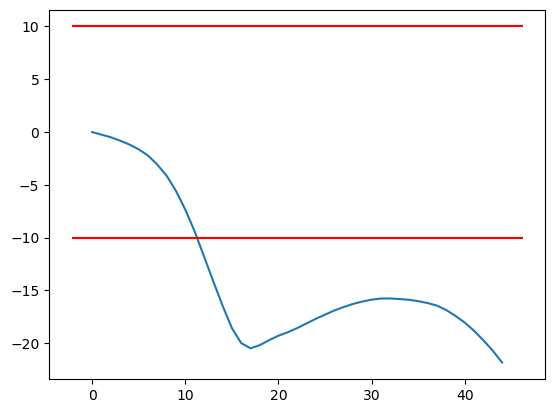

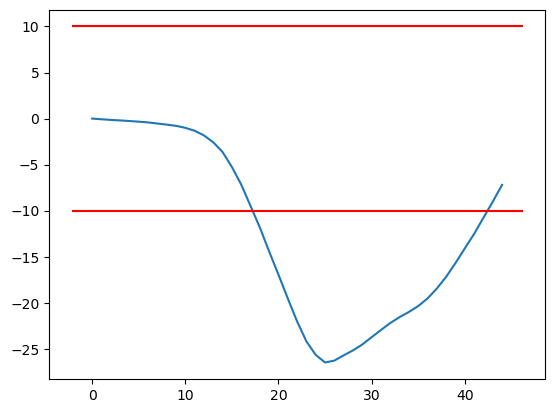

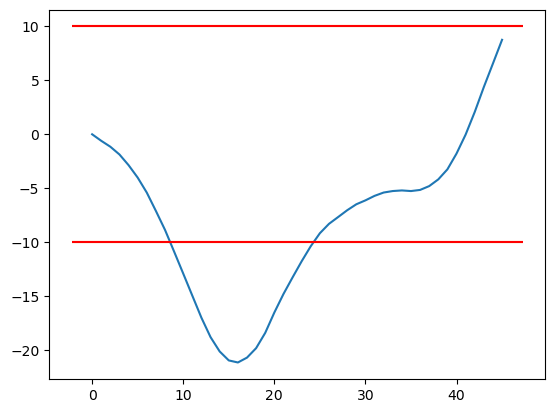

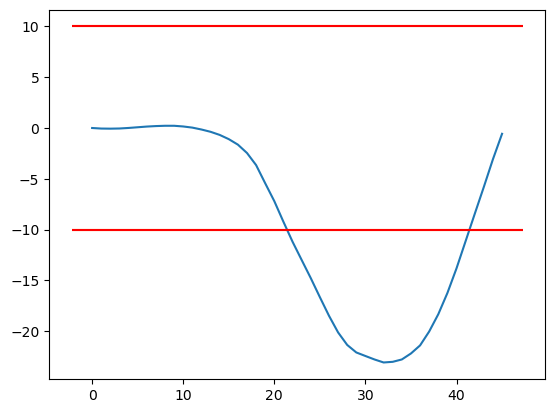

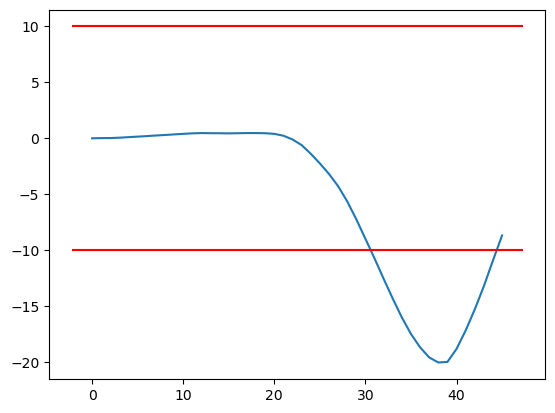

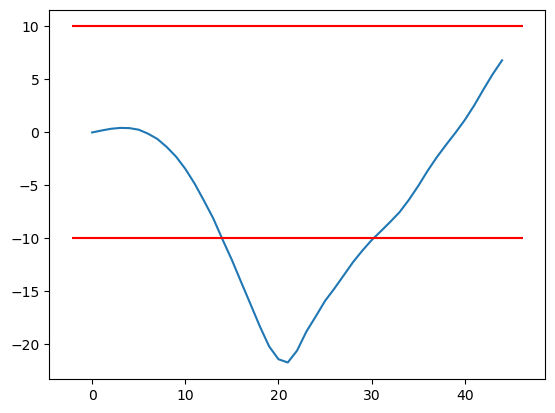

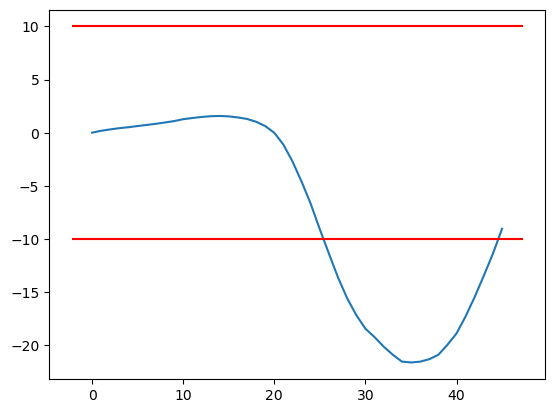

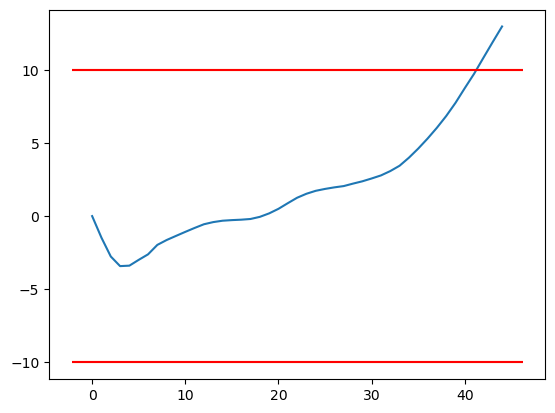

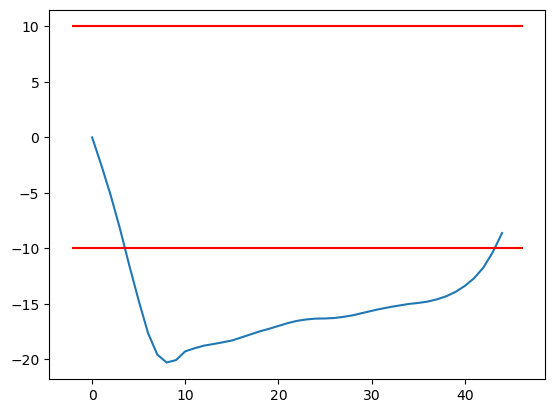

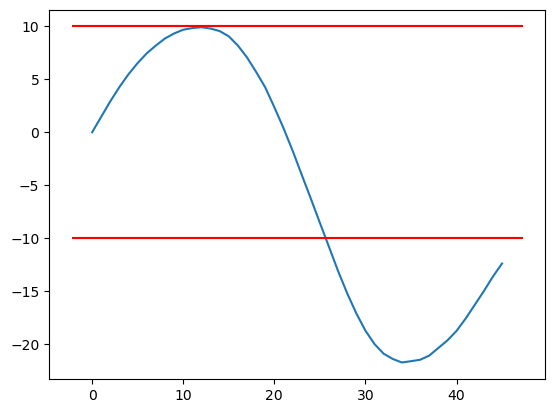

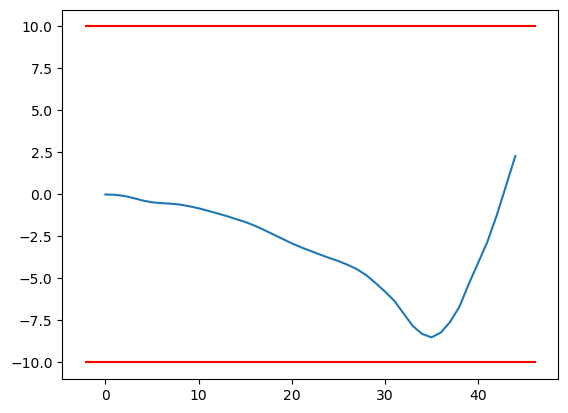

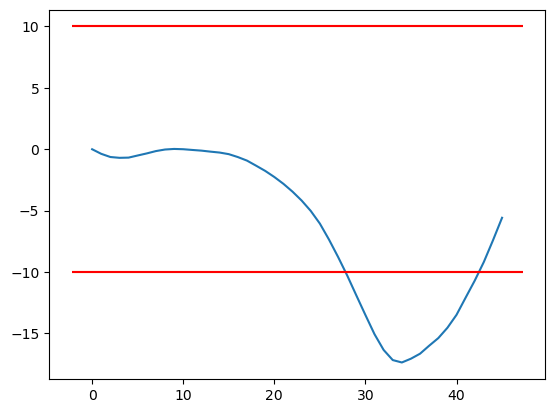

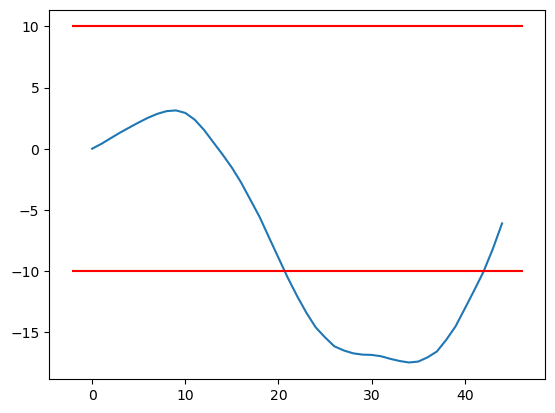

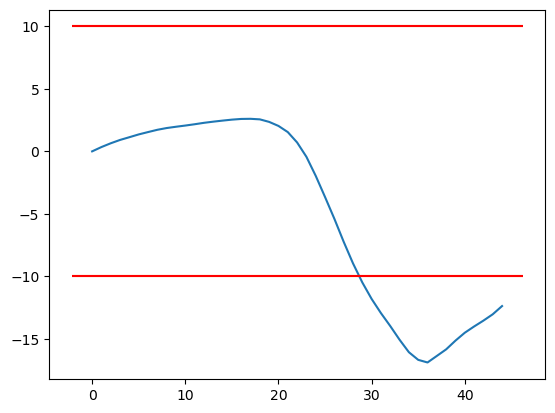

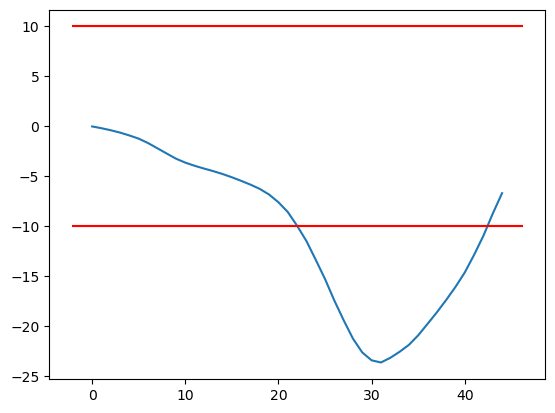

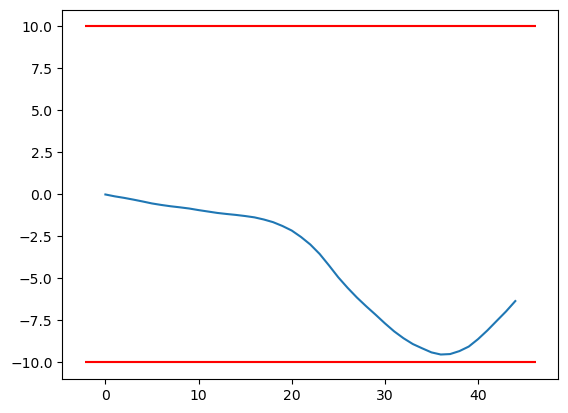

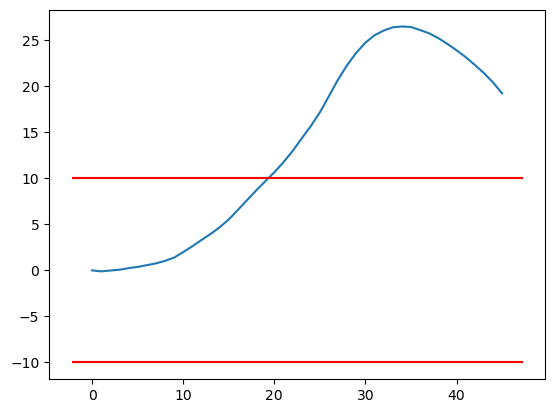

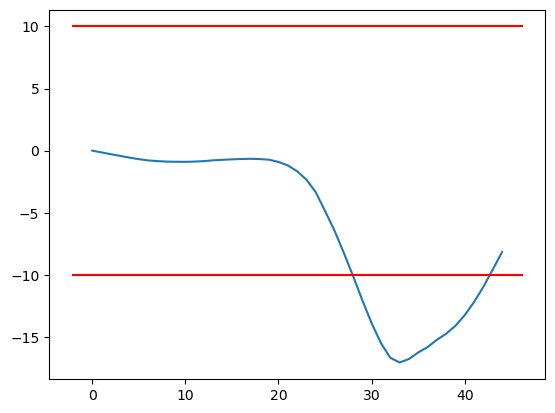

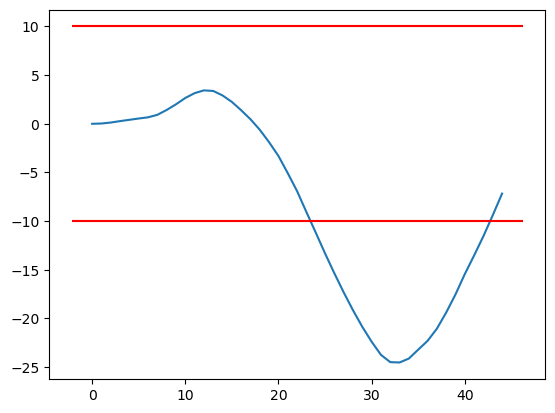

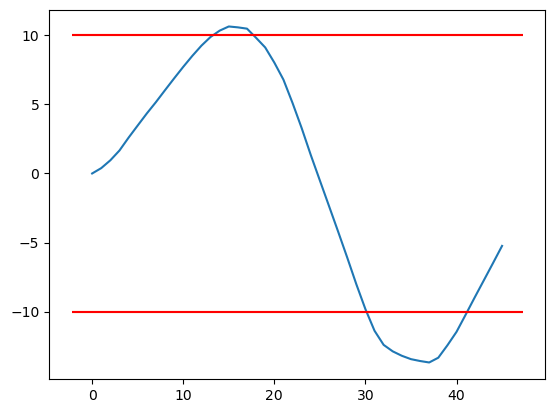

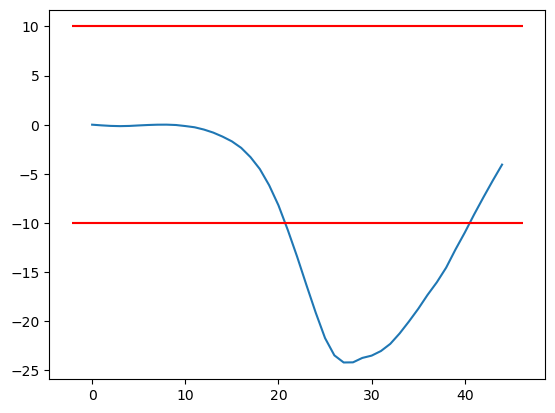

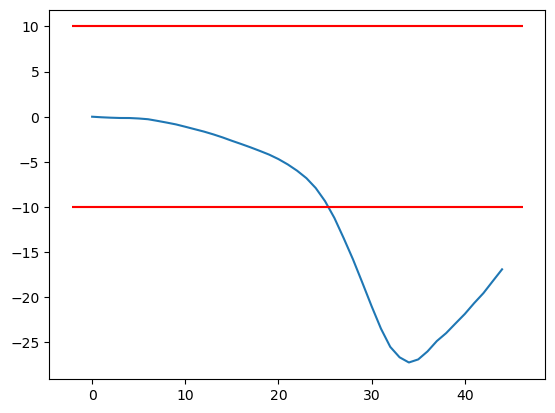

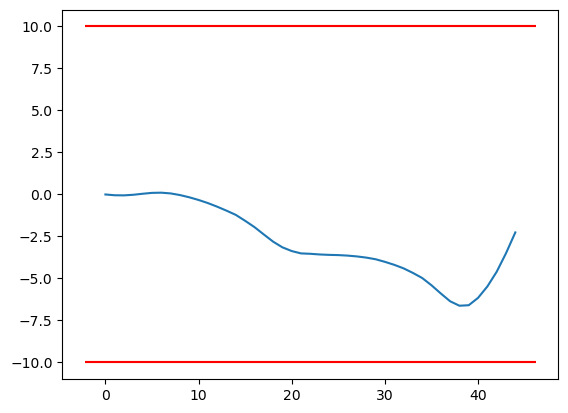

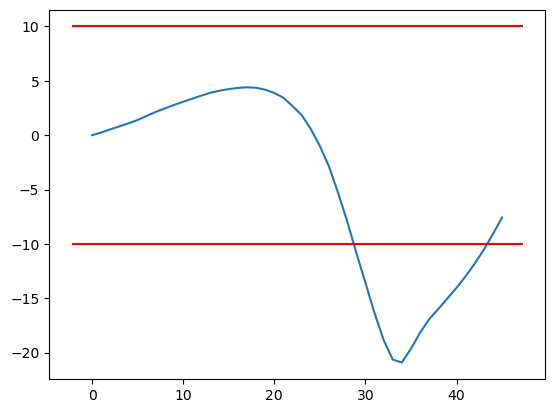

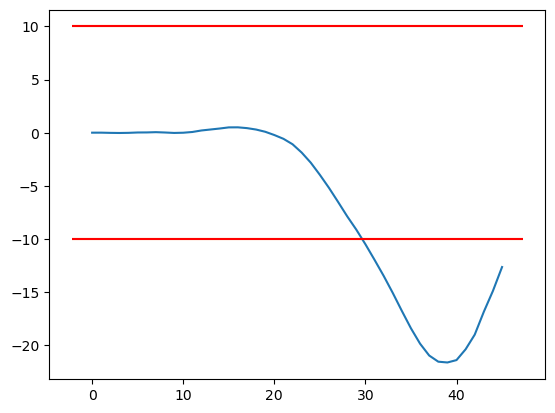

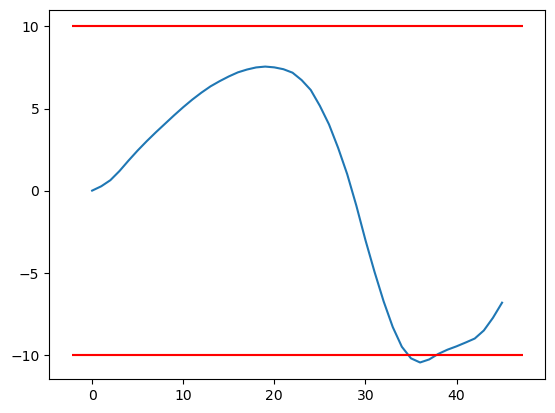

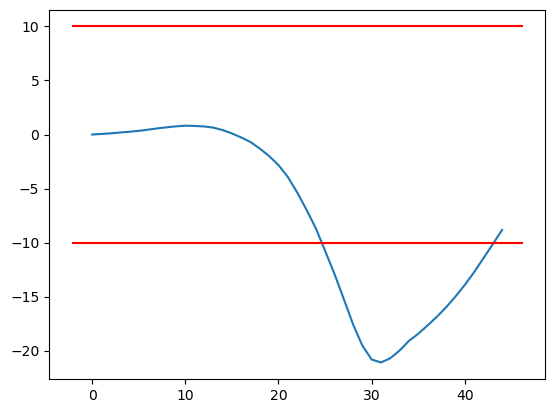

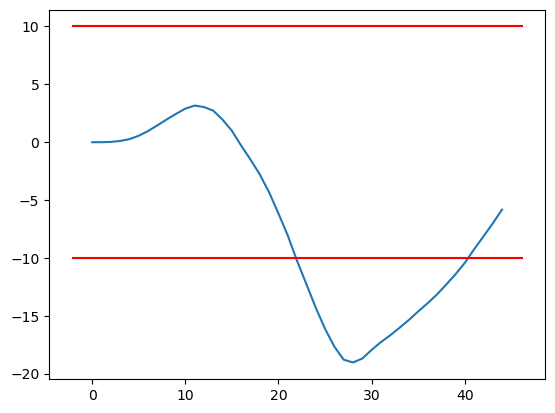

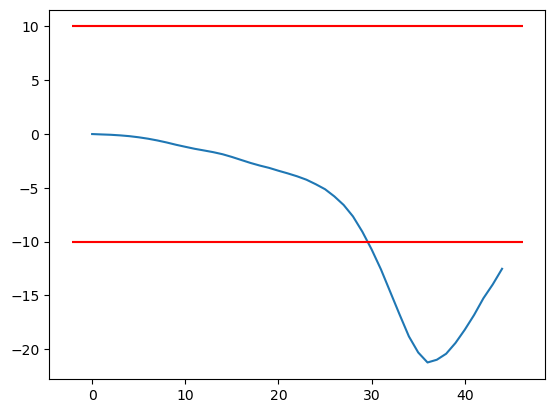

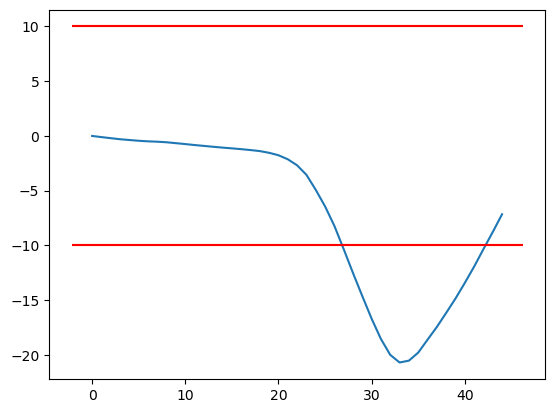

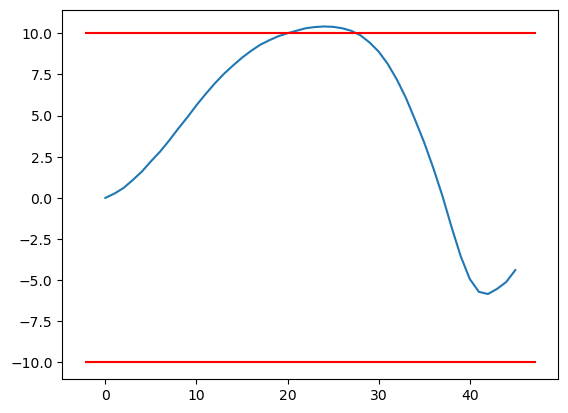

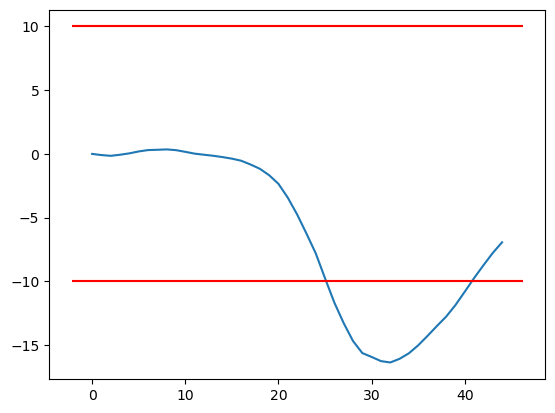

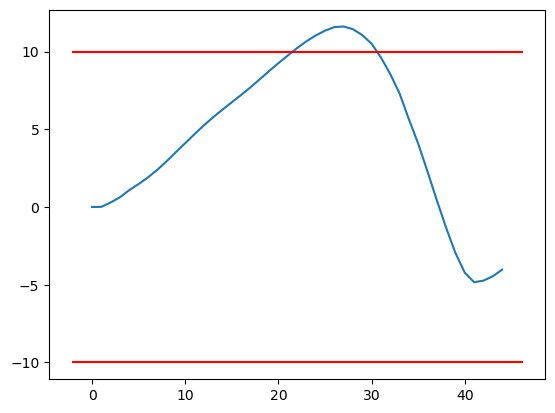

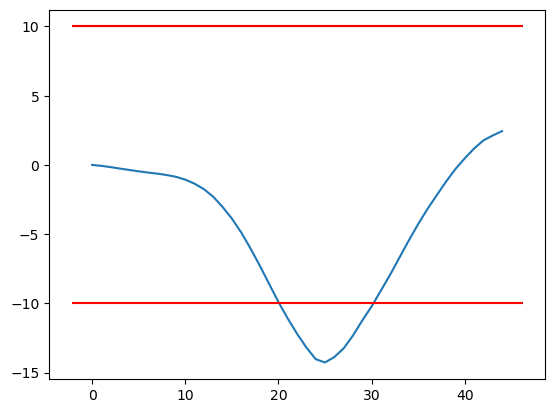

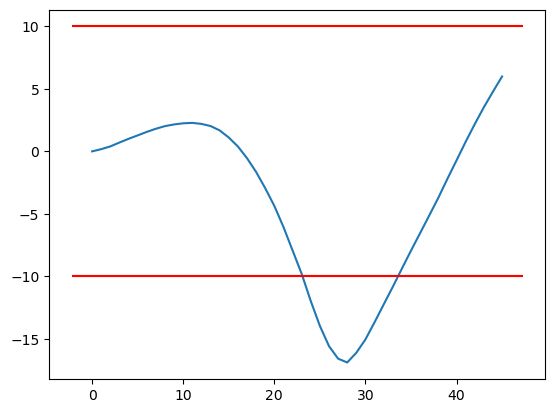

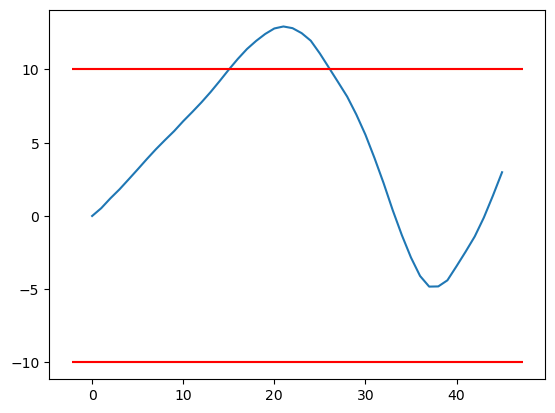

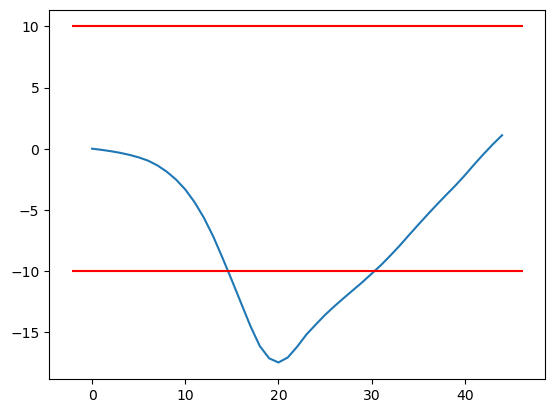

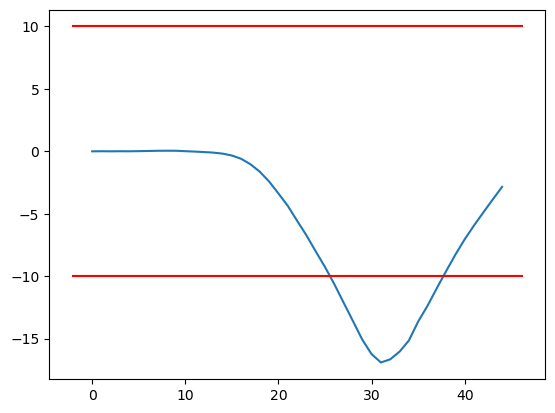

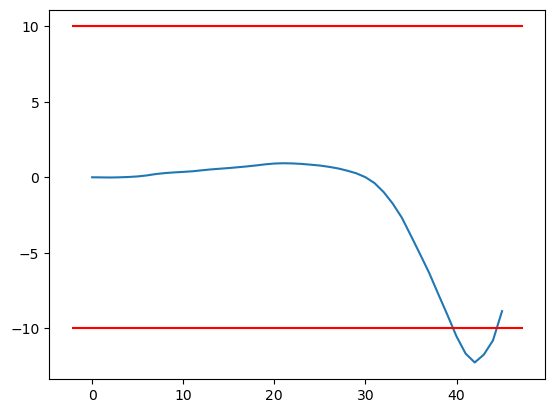

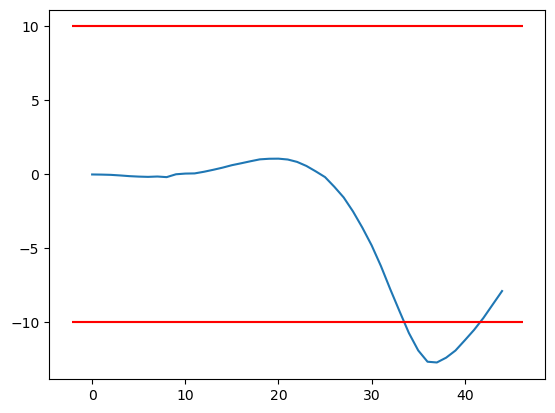

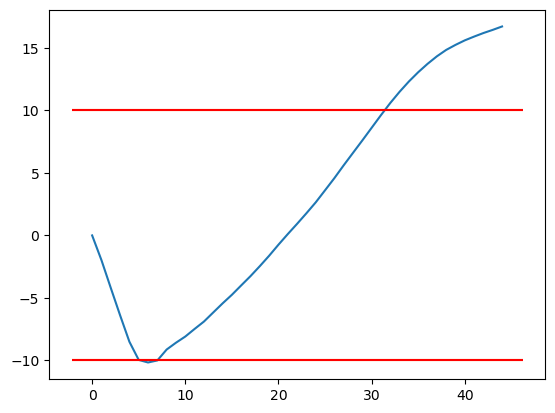

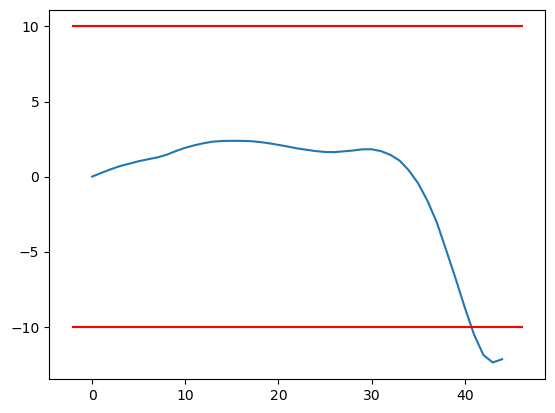

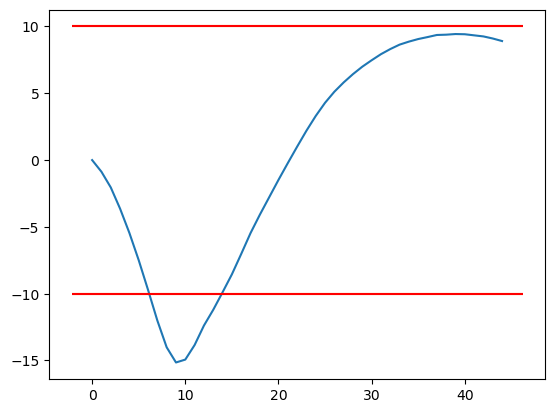

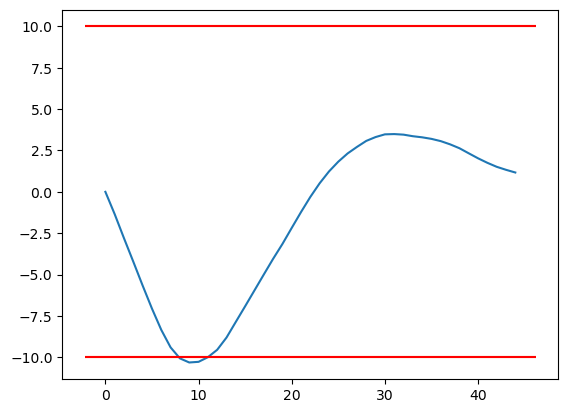

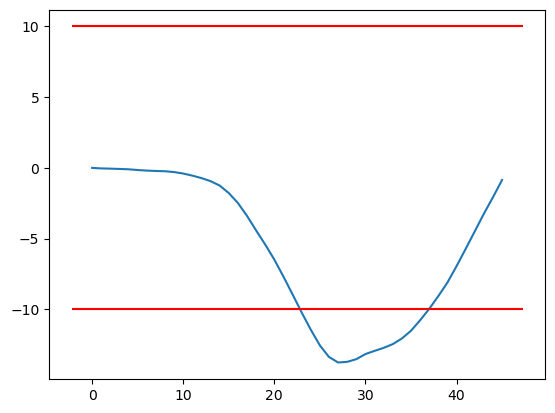

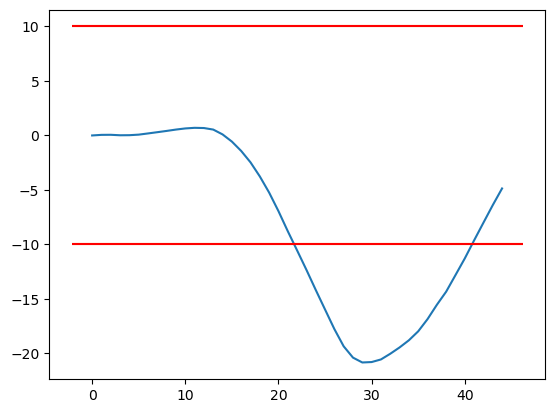

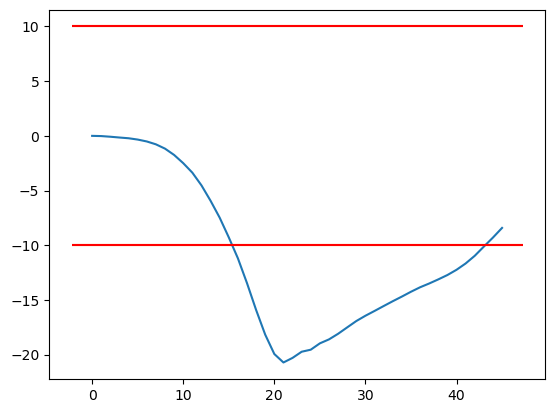

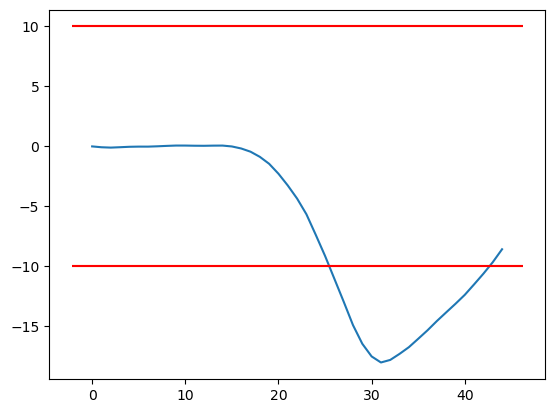

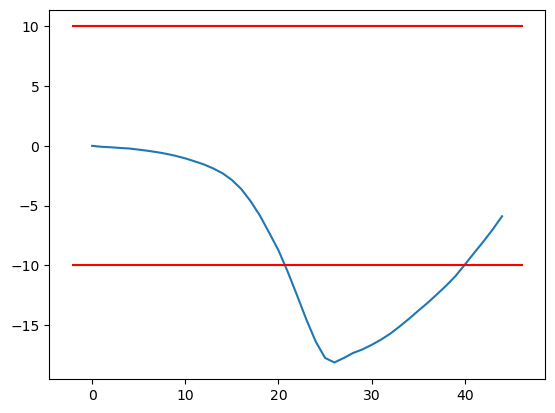

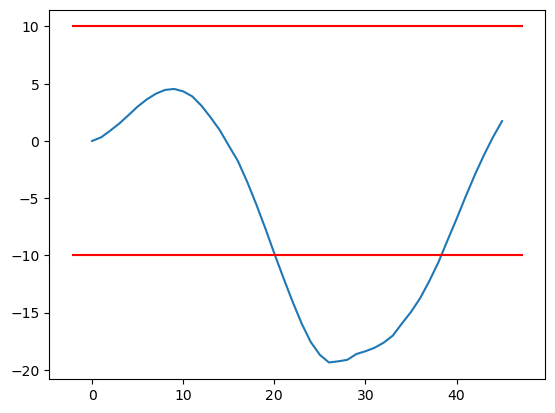

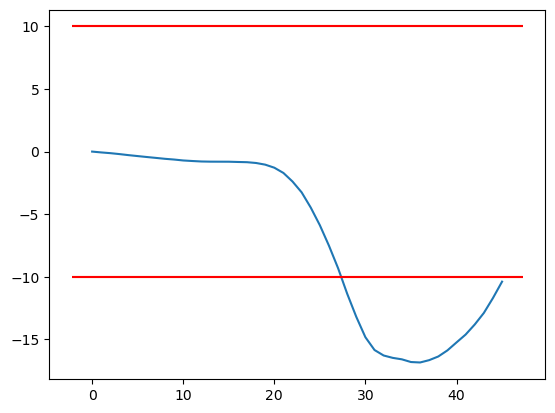

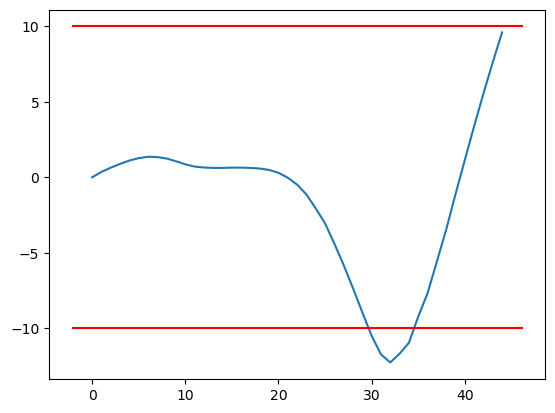

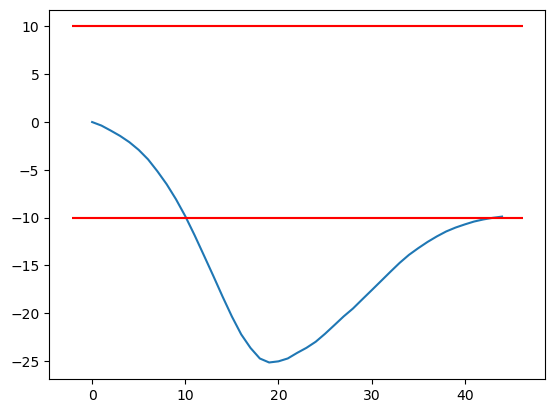

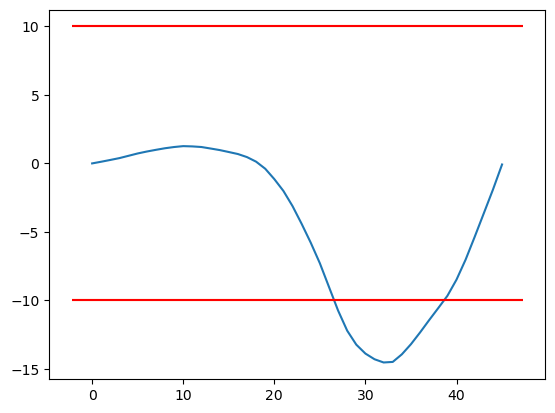

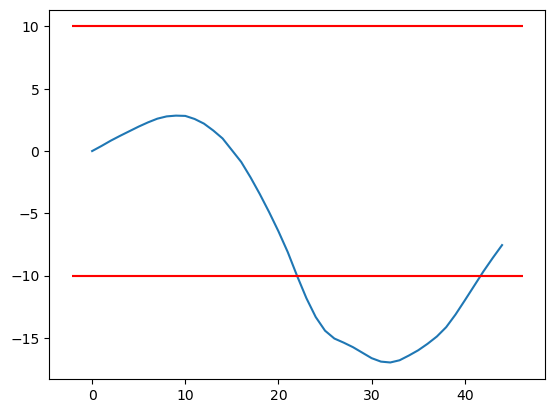

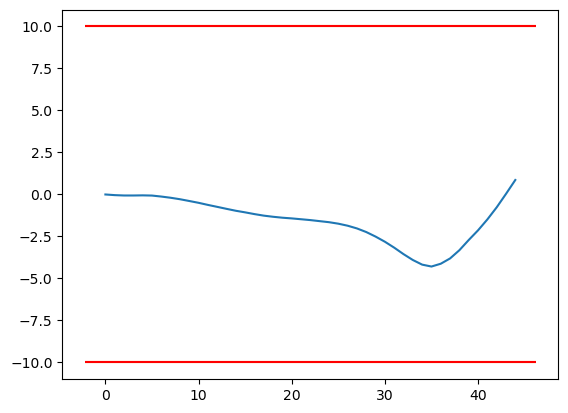

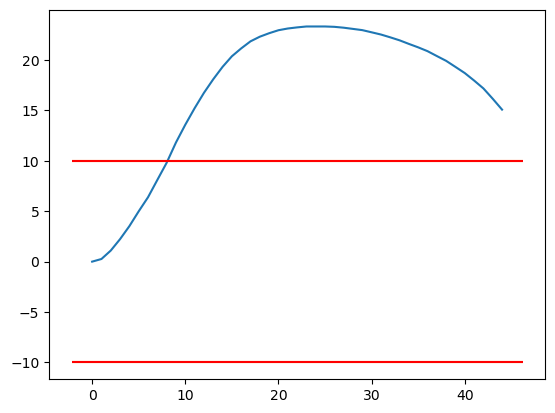

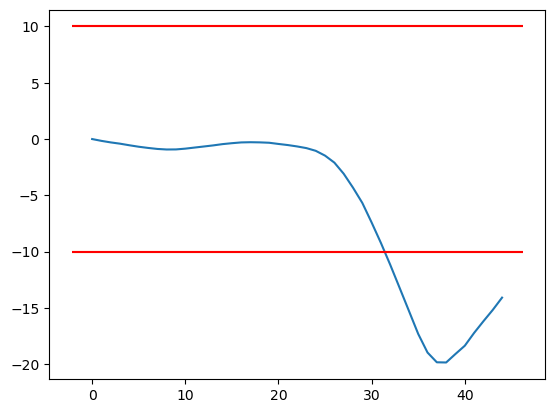

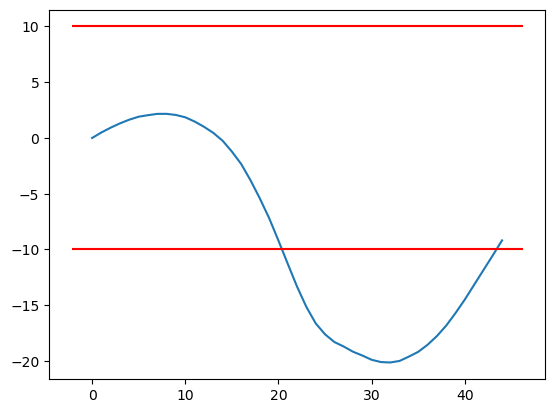

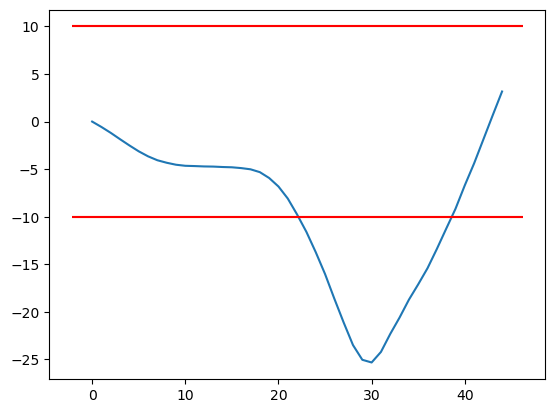

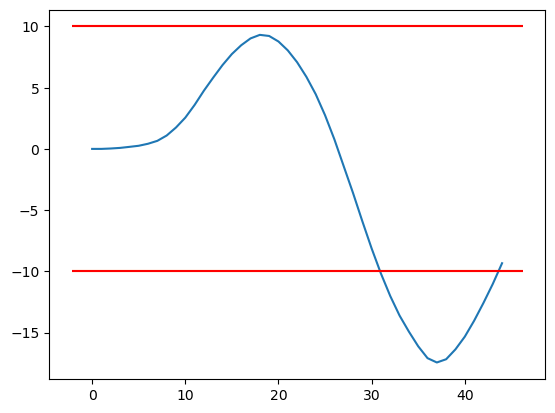

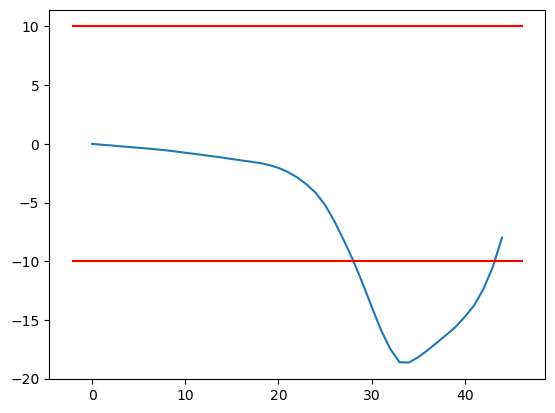

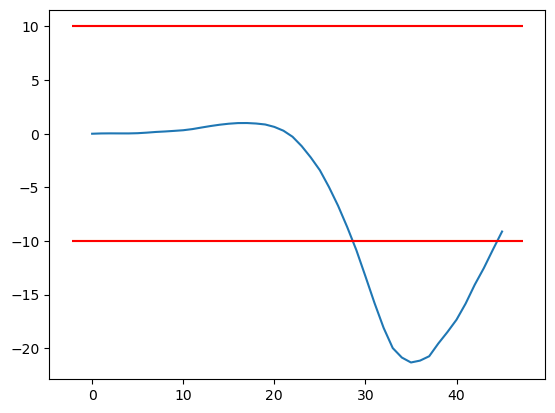

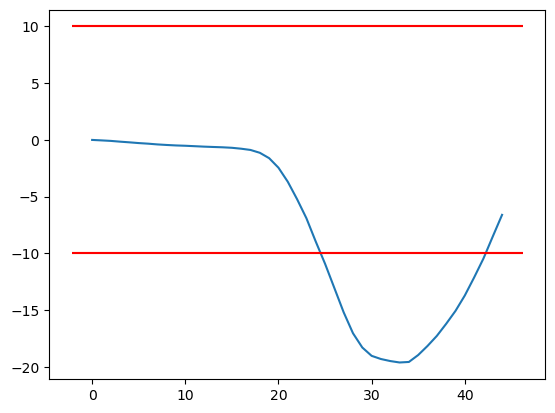

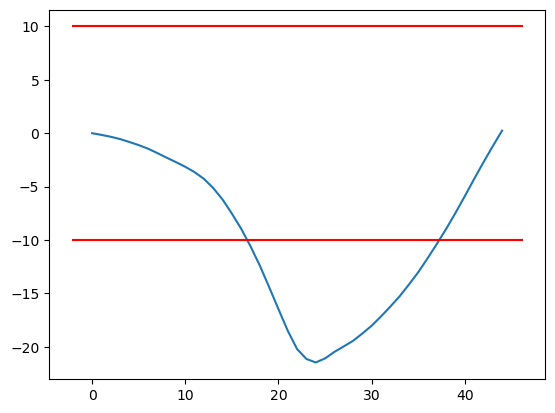

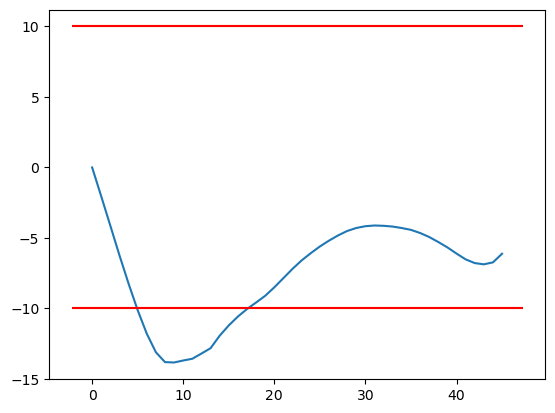

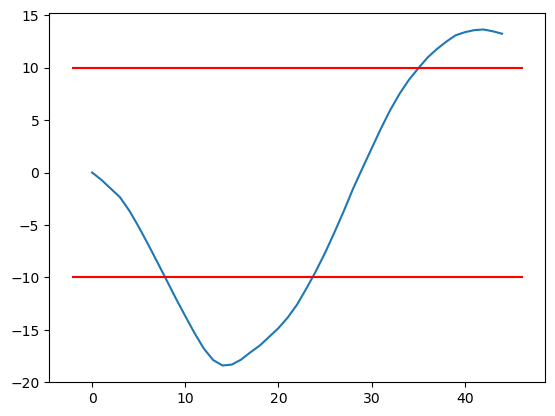

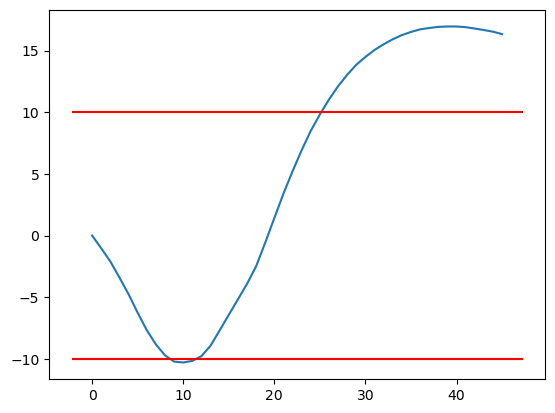

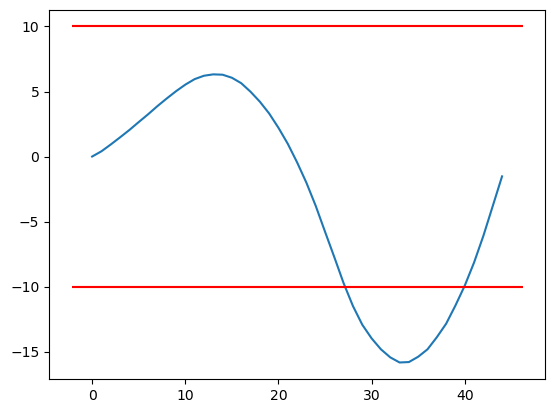

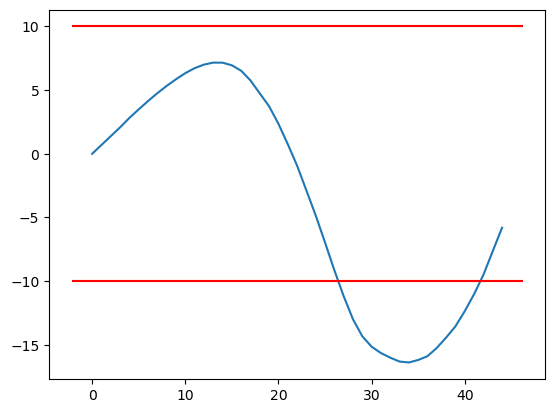

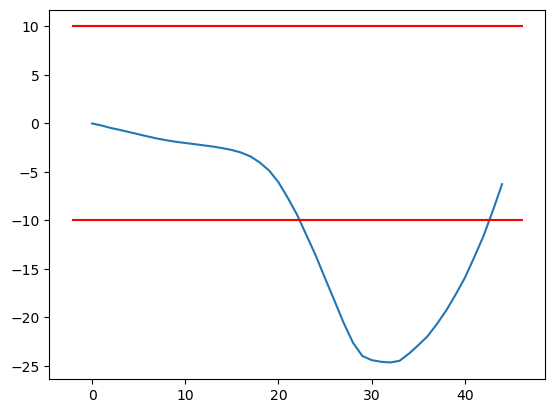

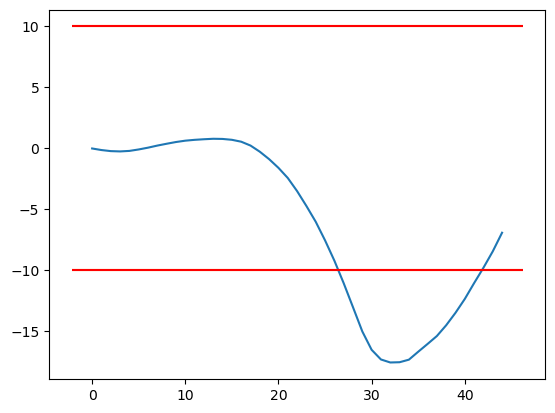

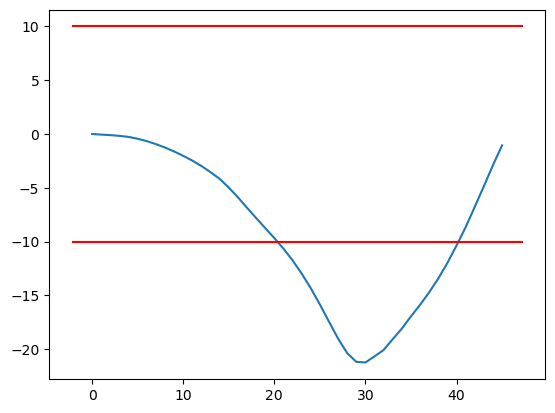

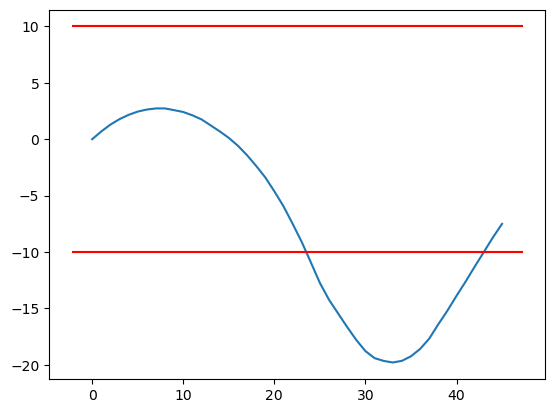

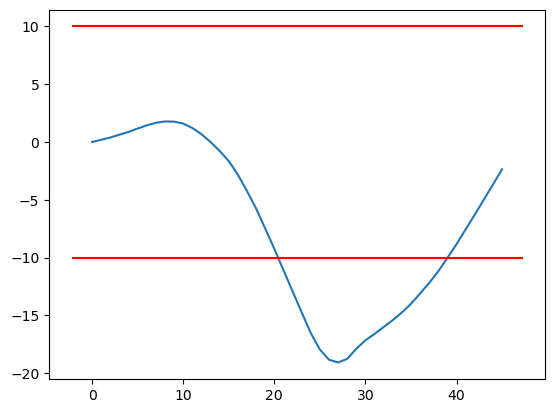

In [155]:
import matplotlib.pyplot as plt
msg_search = "Correct target selected"
final_rounds = rec.get_final_rounds("nod")
deg_end = final_rounds["DegreeEnd"].to_numpy()[0]
deg_move = final_rounds["DegreeMove"].to_numpy()[0]
t = final_rounds["StartDeviceTime"].to_numpy()[0]
idx_select = df.loc[(df.Msg == "Correct target selected") & (df.EyeDataTimestamp > t)].index
# fig, ax = plt.subplots()
for idx in idx_select:
    timestamp = df.loc[idx-1].EyeDataTimestamp

    df_interest = df.loc[(df.EyeDataTimestamp > (timestamp - 500)) & (df.EyeDataTimestamp <= timestamp)]

    cols = ["Main CameraRot%s" % x for x in ["X", "Y", "Z", "W"]]

    up_vector = None 
    vert_moves = list()
    for _, row in df_interest.iterrows():
        r = R.from_quat(row[cols].to_numpy()).as_matrix()
        if up_vector is None:
            up_vector = r.dot(np.array([0, 1, 0]))
        forward_vector = r.dot(np.array([0, 0, 1]))

        # angle = utils.angle_between(up_vector, forward_vector)
        angle = np.arcsin(np.dot(up_vector, forward_vector)) * 180 / np.pi
        vert_moves.append(angle)
        
    plt.plot(vert_moves)
    x_min, x_max = plt.xlim()
    # plt.hlines([-deg_end, -deg_move], x_min, x_max)
    plt.hlines(deg_end, x_min, x_max, color='orange')
    plt.hlines(deg_move, x_min, x_max, color='red')
    plt.hlines(-deg_end, x_min, x_max, color='orange')
    plt.hlines(-deg_move, x_min, x_max, color='red')
    plt.show()

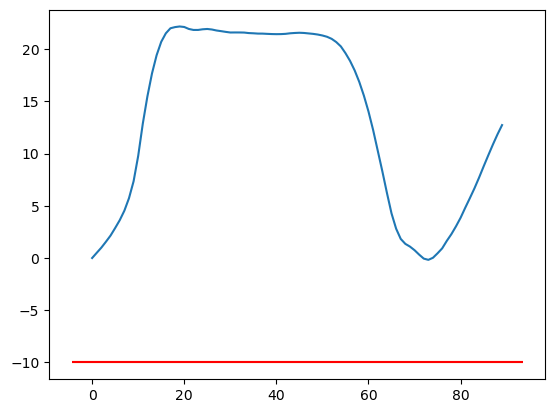

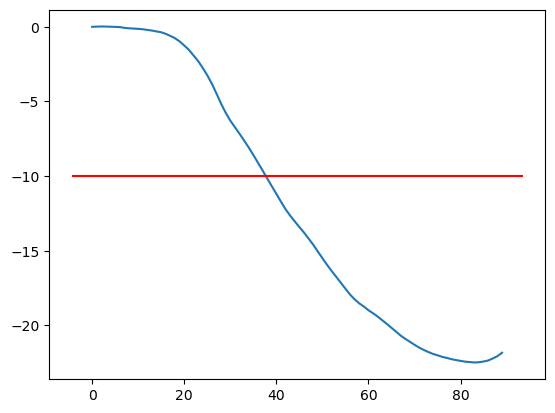

In [156]:
import matplotlib.pyplot as plt
msg_search = "Correct target selected"
final_rounds = rec.get_final_rounds("nod")
deg_end = final_rounds["DegreeEnd"].to_numpy()[0]
deg_move = final_rounds["DegreeMove"].to_numpy()[0]
t = final_rounds["StartDeviceTime"].to_numpy()[0]
idx_select = df.loc[(df.Msg == "Incorrect target selected") & (df.EyeDataTimestamp > t)].index
# fig, ax = plt.subplots()
for idx in idx_select:
    timestamp = df.loc[idx-1].EyeDataTimestamp

    df_interest = df.loc[(df.EyeDataTimestamp > (timestamp - 1000)) & (df.EyeDataTimestamp <= timestamp)]

    cols = ["Main CameraRot%s" % x for x in ["X", "Y", "Z", "W"]]

    up_vector = None 
    vert_moves = list()
    for _, row in df_interest.iterrows():
        r = R.from_quat(row[cols].to_numpy()).as_matrix()
        if up_vector is None:
            up_vector = r.dot(np.array([0, 1, 0]))
        forward_vector = r.dot(np.array([0, 0, 1]))

        # angle = utils.angle_between(up_vector, forward_vector)
        angle = np.arcsin(np.dot(up_vector, forward_vector)) * 180 / np.pi
        vert_moves.append(angle)
        
    plt.plot(vert_moves)
    x_min, x_max = plt.xlim()
    # plt.hlines([-deg_end, -deg_move], x_min, x_max)
    plt.hlines(-deg_end, x_min, x_max, color='orange')
    plt.hlines(-deg_move, x_min, x_max, color='red')
    plt.show()

In [157]:
scene.Msg.unique()

array([nan, 'StartGame', 'Correct target selected', 'MainTargetDestroyed',
       'EndGame', 'Incorrect target selected', 'NonMaintargetDestroyed',
       'robot2 selected'], dtype=object)

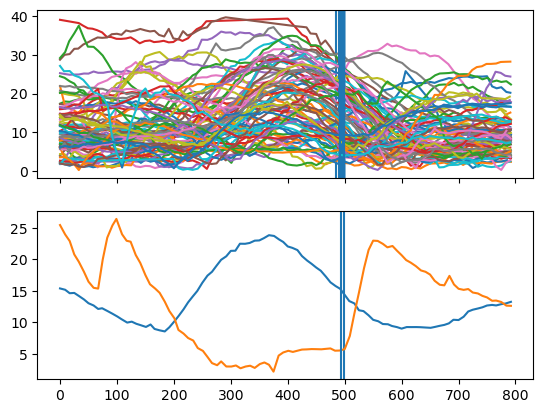

In [158]:
cond = "nod"
gaze = rec[cond]["Gaze120"]
scene = rec[cond]["SceneData"]
timestamps = scene.loc[scene.Msg.astype(str).apply(lambda x: "target selected" in x)].EyeDataTimestamp.to_numpy()
msgs = scene.loc[scene.Msg.astype(str).apply(lambda x: "target selected" in x)].Msg.to_numpy()
res = list()
for t, msg in zip(timestamps, msgs):
    gaze_use = gaze.loc[(gaze["System Timestamp"] > t - 500) & (gaze["System Timestamp"] < t+300)]
    gvs = gaze_use[["Local Gaze Direction %s" % x for x in ["X", "Y", "Z"]]].to_numpy()
    angles = [utils.angle_between(np.array([0, 0, 1]), x) for x in gvs]
    res.append({
        "Time": gaze_use["System Timestamp"].to_numpy(),
        "Angles": angles,
        "Select time": t,
        "Correct": "Correct" in msg
    })

fig, (ax1, ax2) = plt.subplots(2, sharex=True)

for x in res:
    ax = ax1 if x["Correct"] else ax2
    t = x["Time"] - x["Time"][0]
    ax.plot(t, x["Angles"])
    ax.axvline(x["Select time"] - x["Time"][0])
